In [ ]:
# Standard Libraries
import re
import string
import time
from datetime import datetime
from functools import lru_cache

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import html

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Utilities
from tqdm import tqdm
tqdm.pandas()


In [5]:
import nltk
nltk.download(['wordnet', 'stopwords', 'punkt'])  # All required resources

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dyo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data Collection

### We designed a custom query to extract all questions tagged with nlp, capturing both metadata and content-level information. The query filters for posts with the nlp tag and retrieves associated attributes such as question title, body, creation date, answer statistics, and accepted answer information when available. An example SQL query used is shown in paper:

  'https://stackoverflow.com/q/'


In [3]:
df = pd.read_csv("so_nlp_post.csv")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20430 entries, 0 to 20429
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   QuestionId           20430 non-null  int64  
 1   Title                20430 non-null  object 
 2   Body                 20430 non-null  object 
 3   CreationDate         20430 non-null  object 
 4   Tags                 20430 non-null  object 
 5   Score                20430 non-null  int64  
 6   ViewCount            20430 non-null  int64  
 7   AnswerCount          20430 non-null  int64  
 8   AcceptedAnswerId     8509 non-null   float64
 9   AcceptedAnswerBody   8509 non-null   object 
 10  AcceptedAnswerScore  8509 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 1.7+ MB


In [9]:
df.head(20)

,QuestionId,Title,Body,CreationDate,Tags,Score,ViewCount,AnswerCount,AcceptedAnswerId,AcceptedAnswerBody,AcceptedAnswerScore
0,79564180,Natural language processing - Tamil,<p>I'm building a voice-based system where the...,2025-04-09 11:03:00,<machine-learning><nlp><neural-network><artifi...,-5,28,0,NaN,NaN,NaN
1,79559702,NameError: name 'init_empty_weights' is not de...,<p>I am trying to set up hugging face locally ...,2025-04-07 11:02:41,<nlp><huggingface-transformers><huggingface>,2,530,1,NaN,NaN,NaN
2,79557354,Sentencepiece not generating models after prep...,<p>So this is the log that I see on the termin...,2025-04-05 18:21:09,<python><nlp><sentencepiece>,0,53,0,NaN,NaN,NaN
3,79557315,How should I approach the word synonyms for re...,<p>I have created an aspect based list for ana...,2025-04-05 17:32:46,<python><nlp><data-science><sentiment-analysis>,-2,138,1,NaN,NaN,NaN
4,79557313,No attention output in jinaai/jina-embeddings-...,<p>When I use this model like so -</p>\n<pre><...,2025-04-05 17:29:15,<machine-learning><nlp><artificial-intelligenc...,0,25,0,NaN,NaN,NaN
5,79549787,Why does Presidio with spacy nlp engine not re...,<p>I'm using spaCy with the pl_core_news_lg mo...,2025-04-02 05:56:11,<python><nlp><spacy><presidio>,0,89,1,79552218.0,<p>The configuration file is missing the 'labe...,1.0
6,79548202,GPT-2 and other models from huggingface -100 l...,<p>I understand the -100 label id is used so t...,2025-04-01 09:21:17,<nlp><huggingface-transformers><pre-trained-mo...,0,51,1,79551169.0,<p>The author of the tutorial you mentioned se...,1.0
7,79546188,"simpler gmail Filter syntax for ""word family"" ...",<p>Is there simpler filter that I can use for ...,2025-03-31 12:10:55,<filter><nlp><gmail><lemmatization><transliter...,0,28,0,NaN,NaN,NaN
8,79543496,Evaluating Spell Correction Models,<p>How are spell correction models evaluated? ...,2025-03-29 15:50:20,<nlp><precision-recall><spelling>,-1,26,0,NaN,NaN,NaN
9,79533402,Creating regular expression(s) which finds cap...,<blockquote>\n<p>This is a Sentence which cont...,2025-03-25 10:47:13,<regex><nlp><capitalization>,0,66,0,NaN,NaN,NaN


In [25]:
# 1. Inspect Basic DataFrame Info
print("DataFrame Info:")
df.info()
print("\nHead of the DataFrame:")
print(df.head())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20430 entries, 0 to 20429
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   QuestionId           20430 non-null  int64  
 1   Title                20430 non-null  object 
 2   Body                 20430 non-null  object 
 3   CreationDate         20430 non-null  object 
 4   Tags                 20430 non-null  object 
 5   Score                20430 non-null  int64  
 6   ViewCount            20430 non-null  int64  
 7   AnswerCount          20430 non-null  int64  
 8   AcceptedAnswerId     8509 non-null   float64
 9   AcceptedAnswerBody   8509 non-null   object 
 10  AcceptedAnswerScore  8509 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 1.7+ MB

Head of the DataFrame:
   QuestionId                                              Title  \
0    79564180                Natural language processing - Tamil   
1  

In [9]:

# 2. Parse CreationDate as datetime if not already
df["CreationDate"] = pd.to_datetime(df["CreationDate"], errors="coerce")

# 3. Basic Statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
         QuestionId                   CreationDate         Score  \
count  2.043000e+04                          20430  20430.000000   
mean   5.139136e+07  2018-10-22 13:20:50.939794176      2.082624   
min    2.368900e+04            2008-08-22 22:45:10     -7.000000   
25%    3.857478e+07  2016-07-25 18:17:16.249999872      0.000000   
50%    5.637628e+07     2019-05-30 10:19:39.500000      1.000000   
75%    6.793540e+07            2021-06-11 10:19:02      2.000000   
max    7.956418e+07            2025-04-09 11:03:00    469.000000   
std    2.072737e+07                            NaN      8.018990   

           ViewCount   AnswerCount  AcceptedAnswerId  AcceptedAnswerScore  
count   20430.000000  20430.000000      8.509000e+03          8509.000000  
mean     2091.337249      1.256926      4.762744e+07             3.937595  
min         8.000000      0.000000      3.668400e+04            -2.000000  
25%       166.000000      1.000000      3.224626e+07            

# 2. Data Preprocessing 


###  Before performing any analysis on our Stack Overflow dataset, we apply several preprocessing tasks to the text fields (Title, Body, and Accepted Answer Body) to clean and normalize the data. 

### (1) HTML Parsing and Code Block Handling


### (2) Error Message Normalization

### (3) Noise and Redundancy Removal

### 4) Tokenization, Lemmatization, and Filtering

### (5) Final Text Construction


In [50]:
CUSTOM_NOISE = {
    "gt", "lt", "quot", "sep", "thanks", "look", "know", "try", "follow", "give",
    "help", "example", "case", "create", "want", "need", "got", "using"
}


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Technical term sets with case normalization
TECH_STOPWORDS = {'model', 'algorithm', 'data', 'use', 'using'}
PRESERVED_TERMS = {t.lower() for t in {
    'bert', 'nltk', 'spacy', 'transformer', 'word2vec', 'gpt-3', 
    'lstm', 'crf', 'ner', 'pos', 'tf-idf'
}}
TECH_ENTITIES = {e.lower() for e in {
    'python', 'java', 'tensorflow', 'pytorch', 'huggingface',
    'keras', 'sklearn', 'numpy', 'pandas', 'flair'
}}

# Compile regex patterns for better performance
URL_PATTERN = re.compile(r'http\S+|www\S+|https\S+')
EMAIL_PATTERN = re.compile(r'\S*@\S*\s?')
PUNCTUATION_PATTERN = re.compile(r'[^\w\s\-\.]')
MULTISPACE_PATTERN = re.compile(r'\s+')
CODE_LANG_PATTERN = re.compile(r'<code class="language-(\w+)">')
ERROR_PATTERNS = [
    re.compile(r'(Traceback.*?\n\s*File.*?\n.*?Error:.*?\n)'),
    re.compile(r'(Error:\s*.+?\n)'),
    re.compile(r'([A-Z]\w+Error:.*?)')
]

@lru_cache(maxsize=1000)
def cached_lemmatize(word, pos='n'):
    """Cache lemmatization results for better performance."""
    return lemmatizer.lemmatize(word, pos=pos)

def preprocess_stackoverflow_post(title, body, 
                                remove_code=True, 
                                keep_errors=True,
                                return_as='text',
                                verbose=False,
                                min_word_length=2):

    
    # 1. Input validation
    if not isinstance(title, str) or not isinstance(body, str):
        raise ValueError("Title and body must be strings")
    
    # 2. Combine and clean HTML
    combined = f"{title.strip()} [SEP] {body.strip()}"
    soup = BeautifulSoup(combined, 'html.parser')
    
    # 3. Handle code blocks
    if remove_code:
        for code in soup.find_all('code'):
            code.decompose()
    else:
        code_langs = set(CODE_LANG_PATTERN.findall(str(soup)))
        if code_langs:
            soup.append(f" [CODETAGS: {','.join(code_langs)}]")
    
    text = soup.get_text(separator=' ', strip=True)
    
    # 4. Preserve error messages
    if keep_errors:
        for pattern in ERROR_PATTERNS:
            for err in set(pattern.findall(text)):
                err_type = re.search(r'([A-Z]\w+Error)', err[0] if isinstance(err, tuple) else err)
                if err_type:
                    text = text.replace(err, f'[ERROR: {err_type.group(1)}] ')
    
    # 5. Advanced text cleaning
    text = html.unescape(text)
    text = URL_PATTERN.sub('', text)
    text = EMAIL_PATTERN.sub('', text)
    text = PUNCTUATION_PATTERN.sub(' ', text)
    
    # 6. Token processing
    words = []
    if SPACY_AVAILABLE:
        doc = nlp(text.lower())
        for token in doc:
            word = token.text
            if len(word) < min_word_length:
                continue
                
            if word in PRESERVED_TERMS or word in TECH_ENTITIES:
                words.append(word)
                continue
                
            if token.is_alpha and not token.is_stop:
                lemma = cached_lemmatize(
                    word, 
                    pos='v' if token.pos_ == 'VERB' else 'n'
                )
                if (lemma not in stop_words and 
                    lemma not in TECH_STOPWORDS and
                    lemma not in CUSTOM_NOISE and
                    len(lemma) >= min_word_length):
                    words.append(lemma)
    else:
        # NLTK fallback
        tokens = word_tokenize(text.lower())
        for word in tokens:
            if len(word) < min_word_length or not word.isalpha():
                continue
                
            if word in PRESERVED_TERMS or word in TECH_ENTITIES:
                words.append(word)
                continue
                
            if word not in stop_words and word not in TECH_STOPWORDS:
                lemma = cached_lemmatize(word)
                if len(lemma) >= min_word_length:
                    words.append(lemma)
    
    # 7. Final formatting
    processed_text = MULTISPACE_PATTERN.sub(' ', ' '.join(words)).strip()
    
    if verbose:
        sample_output = processed_text[:100] + '...' if len(processed_text) > 100 else processed_text
        print(f"Original title: {title[:60]}...")
        print(f"Processed text: {sample_output}")
        print(f"Token count: {len(words)}")
        print("-" * 50)
    
    return processed_text if return_as == 'text' else words

In [26]:
import nltk
nltk.download(['wordnet', 'stopwords', 'punkt'])  # All required resources
nltk.download('omw-1.4')  # For extended WordNet lemmatizer support


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Antomiao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Antomiao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Antomiao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Antomiao\AppData\Roaming\nltk_data...


True

In [ ]:
# Apply preprocessing with progress bar
df['ProcessedText'] = df.progress_apply(
    lambda row: preprocess_stackoverflow_post(
        title=row['Title'],
        body=row['Body'],
        remove_code=True,          
        keep_errors=True,          
        return_as='text',          
        verbose=False              
    ),
    axis=1
)

# Create separate processed columns
df['ProcessedTitle'] = df['Title'].progress_apply(
    lambda x: preprocess_stackoverflow_post(x, "", remove_code=False)
)
df['ProcessedBody'] = df['Body'].progress_apply(
    lambda x: preprocess_stackoverflow_post("", x)
)

100%|██████████| 20430/20430 [02:15<00:00, 150.48it/s]


In [ ]:
# Check most common words
all_words = ' '.join(df['ProcessedText']).split()
word_counts = Counter(all_words)
print(word_counts.most_common(20))

[('word', 20337), ('text', 13930), ('sentence', 11421), ('like', 10969), ('code', 9443), ('error', 7990), ('find', 7175), ('work', 6919), ('file', 6704), ('list', 6159), ('python', 6156), ('way', 5974), ('output', 5661), ('nlp', 5284), ('train', 5144), ('document', 5050), ('problem', 4669), ('language', 4489), ('extract', 4226), ('result', 4173)]


In [31]:
df.to_csv('preprocess_nlp_post.csv')

In [15]:
# Generate Tables (Descriptive Statistics)
print("\nDescriptive Statistics (numeric columns):")
print(df.describe())


Descriptive Statistics (numeric columns):
         QuestionId                   CreationDate         Score  \
count  2.043000e+04                          20430  20430.000000   
mean   5.139136e+07  2018-10-22 13:20:50.939794176      2.082624   
min    2.368900e+04            2008-08-22 22:45:10     -7.000000   
25%    3.857478e+07  2016-07-25 18:17:16.249999872      0.000000   
50%    5.637628e+07     2019-05-30 10:19:39.500000      1.000000   
75%    6.793540e+07            2021-06-11 10:19:02      2.000000   
max    7.956418e+07            2025-04-09 11:03:00    469.000000   
std    2.072737e+07                            NaN      8.018990   

           ViewCount   AnswerCount  AcceptedAnswerId  AcceptedAnswerScore  
count   20430.000000  20430.000000      8.509000e+03          8509.000000  
mean     2091.337249      1.256926      4.762744e+07             3.937595  
min         8.000000      0.000000      3.668400e+04            -2.000000  
25%       166.000000      1.000000      

# 3. Data Visualisation


In [34]:
df = pd.read_csv('preprocess_nlp_post.csv')


In [37]:
# Set plot style for better appearance
sns.set(style="whitegrid")

# Figure 3.1: Histogram of ViewCount


### Original histogram of ViewCount is skewed due to extremely high outlier values in the ViewCount column (e.g., some posts have tens or hundreds of thousands of views, while most have < 1000). 

### Therefore, Log-transform the view counts to compress outliers. 

### Also, use View Count is all larger than 0, then +1 (a standard and safe mathematical trick to handle zero values) is not necessary.

In [36]:
df["ViewCount"].value_counts()

ViewCount
59       65
58       62
61       60
51       56
47       55
         ..
5264      1
49896     1
33213     1
5661      1
2712      1
Name: count, Length: 4892, dtype: int64

In [38]:
df["ViewCount_log"] = df["ViewCount"].apply(lambda x: np.log10(x))

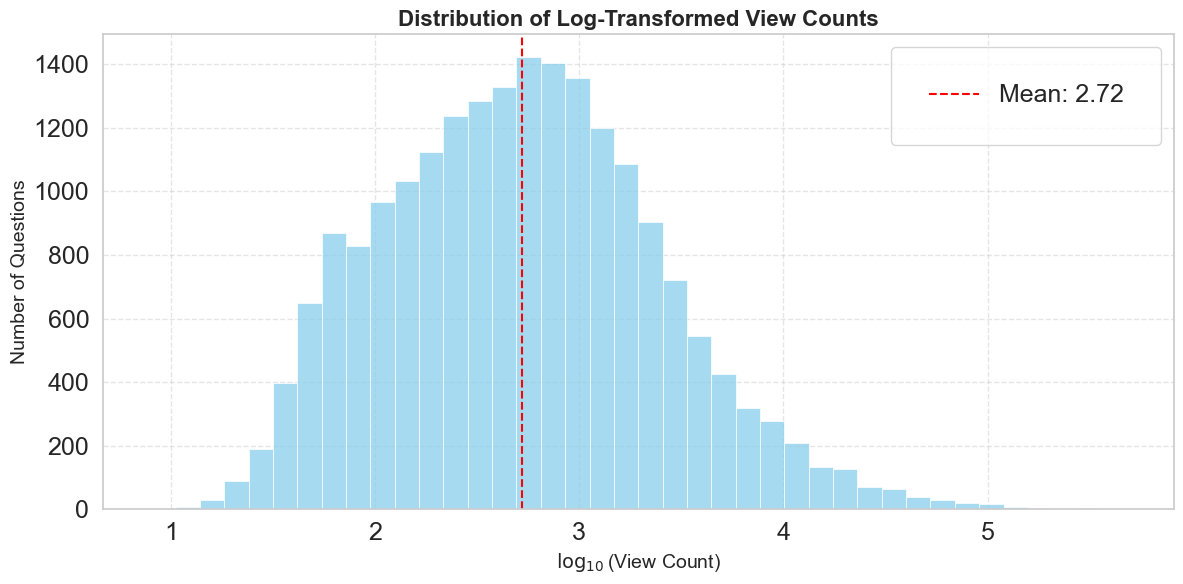

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="ViewCount_log", bins=40, color="skyblue", edgecolor="white", linewidth=0.5)

# Titles and labels
plt.title("Distribution of Log-Transformed View Counts", fontsize=16, fontweight='bold')
plt.xlabel(r"$\log_{10}$(View Count)", fontsize=14)

# plt.xlabel("log10(View Count)", fontsize=14)
plt.ylabel("Number of Questions", fontsize=14)

# Grid and ticks
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Example: Add mean line
mean_log = df["ViewCount_log"].mean()
plt.axvline(mean_log, color="red", linestyle="--", label=f"Mean: {mean_log:.2f}")
plt.legend(fontsize=18, loc="upper right", frameon=True, fancybox=True, borderpad=1.5)

plt.tight_layout()
plt.show()


This plot shows the distribution of log-transformed view counts for Stack Overflow posts tagged with NLP-related terms. The transformation reveals a roughly symmetric distribution centered around log₁₀(View Count) ≈ 2.72, which corresponds to approximately 525 views. The use of log scaling helps compress the long-tailed nature of the original data and improves the visibility of posts with low to medium popularity.


## 3.2 Histogram of ViewCount Score Score 

### column contains negative values, a log-scale x-axis won't work well. So instead of setting a log-scaled x-axis, I create a log-transformed feature that handles positive, zero, and negative values gracefully.

In [23]:
# Safe signed log transform (preserves sign)
df["Score_log"] = df["Score"].apply(lambda x: np.log1p(x) if x >= 0 else -np.log1p(abs(x)))


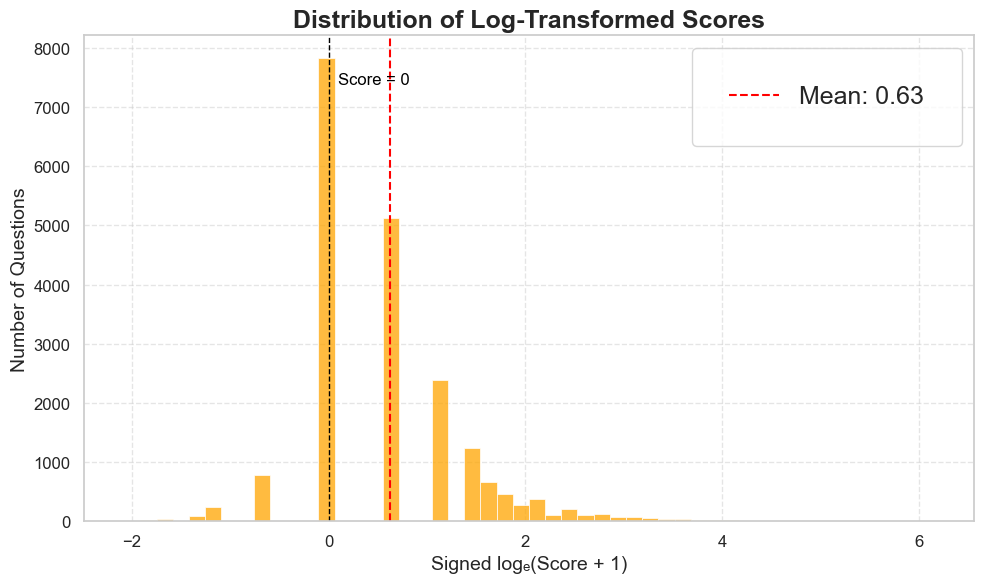

In [24]:
plt.figure(figsize=(10, 6))

# Plot with aesthetics
sns.histplot(
    data=df, 
    x="Score_log", 
    bins=50, 
    color="orange", 
    edgecolor="white", 
    linewidth=0.5
)

# Titles and axis labels
plt.title("Distribution of Log-Transformed Scores", fontsize=18, fontweight='bold')
plt.xlabel("Signed logₑ(Score + 1)", fontsize=14)
plt.ylabel("Number of Questions", fontsize=14)

# Grid and ticks
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional vertical line at zero (original score = 0)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.text(0.1, plt.ylim()[1]*0.9, "Score = 0", fontsize=12, color='black')

# Optional: annotate mean log score
mean_score_log = df["Score_log"].mean()
plt.axvline(mean_score_log, color='red', linestyle='--', label=f"Mean: {mean_score_log:.2f}")
plt.legend(fontsize=18, loc="upper right", frameon=True, fancybox=True, borderpad=1.5)

plt.tight_layout()
plt.show()


In [25]:
original_mean = df["Score"].mean()
print(f"Original mean score: {original_mean:.2f}")


Original mean score: 2.08


This histogram visualizes the signed log transformation of Stack Overflow post scores to handle the long-tailed nature of the original data (which included both highly upvoted and downvoted posts). The transformation compresses extreme values while preserving sign, enabling us to visualize both high and low scoring questions in a single, interpretable plot.  Most questions cluster around a score of zero, with a slight skew toward positively scored posts. A vertical dashed line marks where the original score was zero, and the red dashed line shows the mean log-transformed score (~0.63),original mean score is 2.08, indicating a slight skew toward positively scored questions.


## 3.3 Histogram of AnswerCount

### Limiting the x-axis to 10 and grouping all higher answer counts into a "10+" category helps simplify the visualization and improve readability. Since the vast majority of Stack Overflow questions have between 0 and 10 answers, plotting every individual count—especially rare outliers like 22 or 51—adds clutter and distorts the scale. By grouping these outliers, the plot focuses on the most common patterns while still acknowledging that some posts receive unusually high engagement. This approach keeps the chart clean, interpretable, and visually balanced.

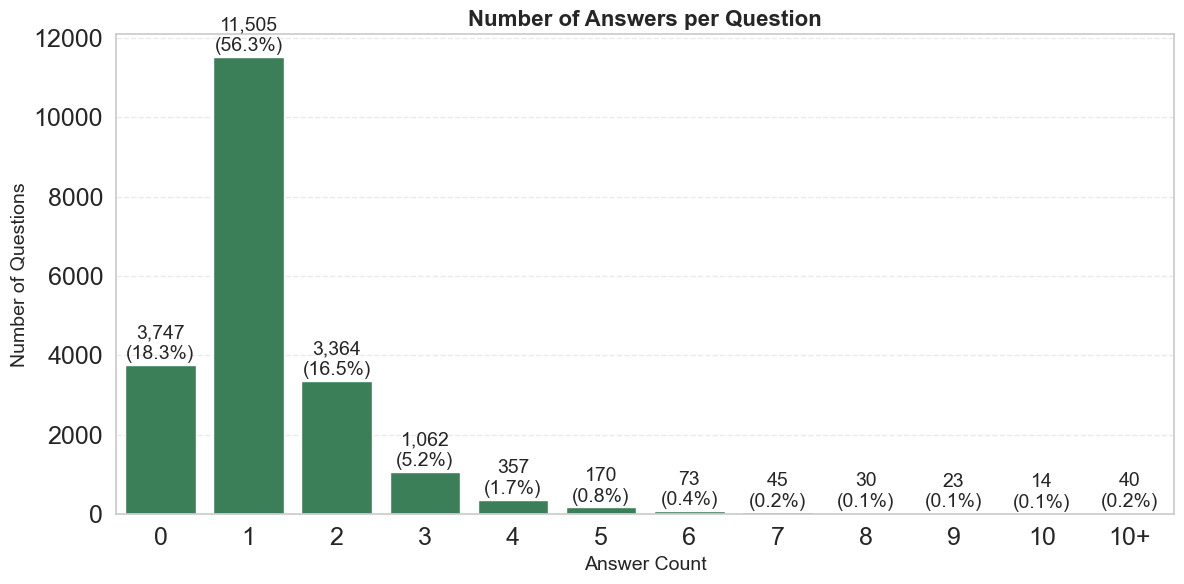

In [28]:
total = len(df_plot)

plt.figure(figsize=(12, 6))
sns.countplot(data=df_plot, x="AnswerCountGroup", order=answer_order, color="seagreen")

# Titles and labels
plt.title("Number of Answers per Question", fontsize=16, fontweight="bold")
plt.xlabel("Answer Count", fontsize=14)
plt.ylabel("Number of Questions", fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Add count + percentage annotations
for p in plt.gca().patches:
    count = p.get_height()
    percentage = count / total * 100
    plt.text(
        p.get_x() + p.get_width() / 2,
        count + 150,
        f"{count:,.0f}\n({percentage:.1f}%)",
        ha='center',
        fontsize=14
    )

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


This bar chart illustrates how many answers each question received, clearly showing a heavily skewed distribution. More than half of the questions (56.3%) have exactly one answer, while nearly a fifth (18.3%) remain unanswered. Another sizeable portion (16.5%) have two answers, and only a small fraction get three or more. The “10+” bin indicates that very few questions draw such extensive engagement. Overall, most questions receive a minimal number of answers, with a noticeable portion getting none at all, highlighting how attention on the platform is often concentrated around a subset of posts.

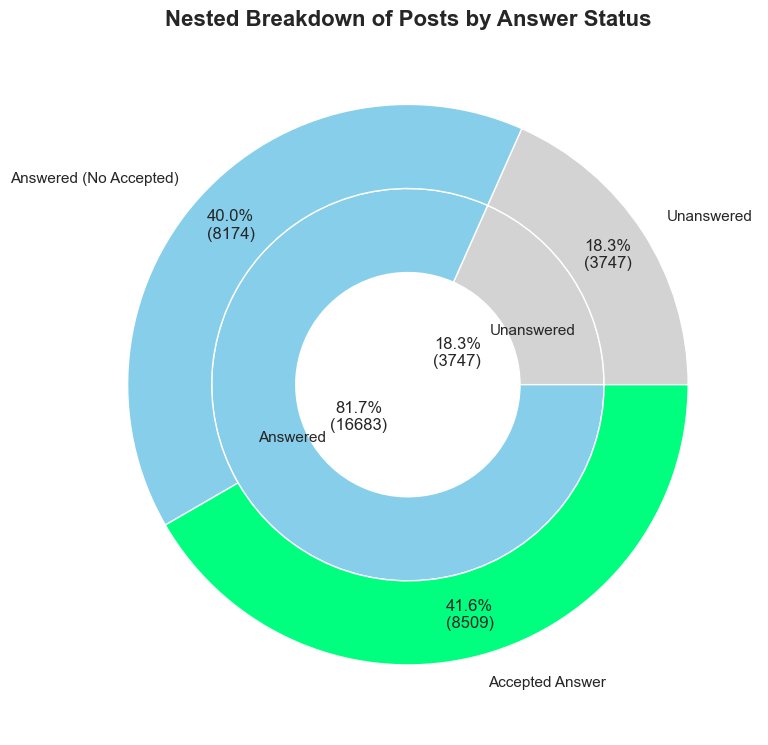

In [29]:
import matplotlib.pyplot as plt

# Function to format autopct label with both percentage and absolute count
def func(pct, allvals):
    absolute = int(round(pct / 100.0 * sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Calculate counts
total_posts = len(df)
unanswered = df[df["AnswerCount"] == 0].shape[0]
answered = total_posts - unanswered  # posts with at least one answer
accepted = df[df["AcceptedAnswerId"].notnull()].shape[0]
answered_no_accept = answered - accepted

# Define data for the inner ring (Unanswered vs. Answered)
inner_labels = ["Unanswered", "Answered"]
inner_sizes = [unanswered, answered]
inner_colors = ["lightgrey", "skyblue"]

# Define data for the outer ring
# Outer ring splits "Answered" into "Answered (No Accepted)" and "Accepted Answer",
# plus the "Unanswered" slice (same count) for a complete outer circle
outer_labels = ["Unanswered", "Answered (No Accepted)", "Accepted Answer"]
outer_sizes = [unanswered, answered_no_accept, accepted]
outer_colors = ["lightgrey", "skyblue", "springgreen"]

fig, ax = plt.subplots(figsize=(8, 8))

# 1. Plot the inner ring with autopct for percentages + counts
ax.pie(
    inner_sizes,
    radius=0.7,
    labels=inner_labels,
    labeldistance=0.5,
    colors=inner_colors,
    autopct=lambda pct: func(pct, inner_sizes),  # <-- autopct for inner ring
    pctdistance=0.3,  # adjusts the position of the numeric labels
    wedgeprops=dict(width=0.3, edgecolor='w')
)

# 2. Plot the outer ring with autopct for percentages + counts
ax.pie(
    outer_sizes,
    radius=1.0,
    labels=outer_labels,
    labeldistance=1.1,
    colors=outer_colors,
    autopct=lambda pct: func(pct, outer_sizes),  # <-- autopct for outer ring
    pctdistance=0.85,
    wedgeprops=dict(width=0.3, edgecolor='w')
)

plt.setp(ax, aspect="equal")
plt.title("Nested Breakdown of Posts by Answer Status", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


This nested donut chart offers a clear, two-level breakdown of Stack Overflow posts by answer status. The inner ring shows that 81.7% of questions are answered (light blue) while 18.3% remain unanswered (gray). The outer ring further divides the answered portion into those with an accepted answer (green) and those without (blue). Notably, 40% of the answered questions lack an accepted answer, whereas 41.6% are fully resolved. This layout highlights how the majority of posts do get at least one response, yet a significant fraction of them never receive an accepted solution.

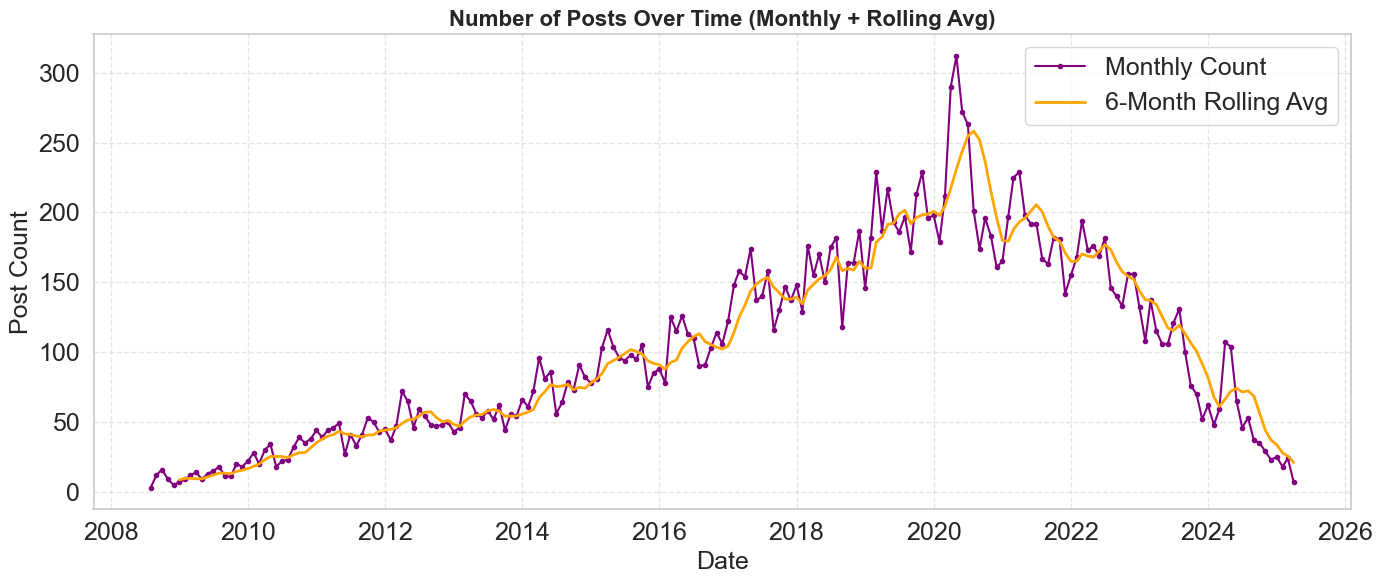

In [ ]:
plt.figure(figsize=(14, 6))

# Plot monthly data with small markers
plt.plot(posts_by_month["Date"], posts_by_month["PostCount"], 
         color="purple", marker="o", markersize=3, label="Monthly Count")

# Plot rolling average
plt.plot(posts_by_month["Date"], posts_by_month["RollingAvg"], 
         color="orange", linewidth=2, label="6-Month Rolling Avg")

plt.title("Number of Posts Over Time (Monthly + Rolling Avg)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Post Count", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=18)

# Fewer year ticks: every 2 years
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


This line chart illustrates the evolution of monthly Stack Overflow post counts over more than a decade, providing both granular details and a smoothed long-term trend. The purple line represents the raw monthly post counts, capturing specific peaks and troughs in user activity, while the orange line overlays a 6‑month rolling average to smooth out short-term fluctuations and emphasize the overall trend. Notably, the data shows a gradual increase in posting activity from around 2008—the year when Stack Overflow was founded，through a period of robust growth up to approximately 2014–2015. The trend peaks around 2020, indicating a period of intense community engagement, before gradually declining in the more recent years. The x-axis includes clearly labeled and spaced dates with actual years, which makes it easy to correlate these variations with external events and shifts in community focus. Overall, the chart effectively balances detailed monthly changes with broader trends, providing valuable insights into the evolution of user engagement on Stack Overflow over the years.

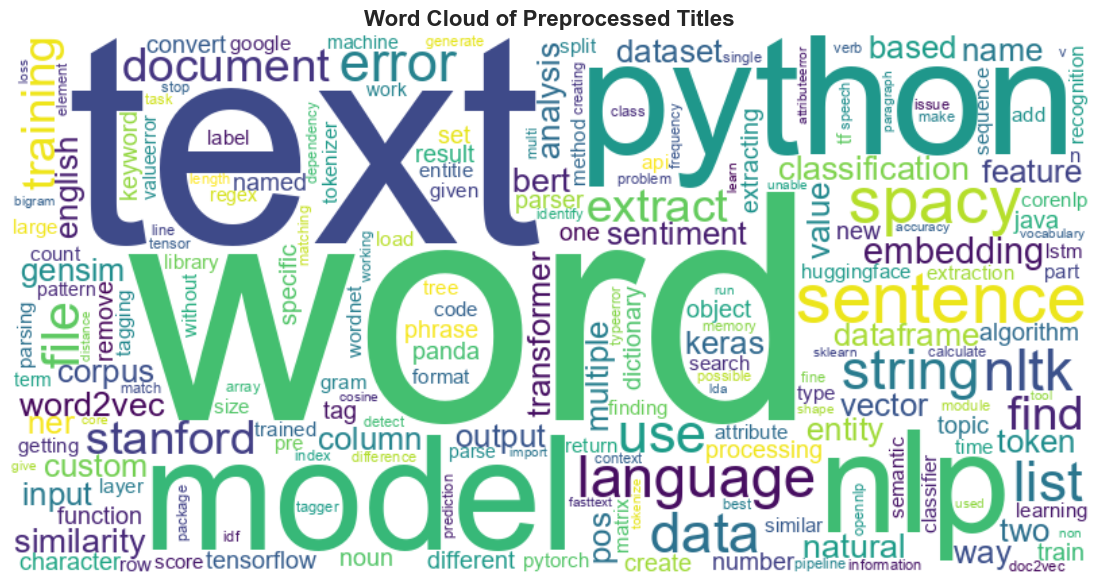

In [ ]:
# Combine preprocessed titles into one large string.
all_text = " ".join(df["Title_preprocessed"].tolist())

# Define extra stopwords as needed.
extra_stopwords = set(STOPWORDS)
extra_stopwords.update(["using", "like", "get", "question", "post"])

# Specify the font_path if necessary; adjust if you're not on Windows or if a different font is preferred.
# For example, on Windows, you might use:
font_path = r"C:\Windows\Fonts\Arial.ttf"

# Create and generate the word cloud.
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color="white",
    stopwords=extra_stopwords,
    collocations=False,   # avoid duplicate phrases
    font_path=font_path   # comment out this line if not needed
).generate(all_text)

# Display the generated image.
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Preprocessed Titles", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


This word cloud offers a quick visual snapshot of the most common terms in the preprocessed question titles, with text size reflecting word frequency. Larger words such as “word,” “text,” “model,” “python,” and “nlp” dominate, indicating that many titles focus on natural language processing tasks, Python-based workflows, and model-centric discussions. Other notably frequent words—like “sentence,” “spacy,” “nltk,” “bert,” and “similarity”， further underscore the community’s emphasis on text manipulation, library usage, and linguistic feature extraction. Overall, the word cloud highlights a strong interest in Python-driven NLP techniques, underscoring the dataset’s focus on practical question-and-answer exchanges around text processing, model building, and language analysis.

In [ ]:
df.to_csv('postcleaned.csv')

# 4. Data Categorization


In [9]:
df_cleaned = pd.read_csv('lightclean_nlp_post.csv')

In [ ]:
texts = df_cleaned["ProcessedText"].fillna("").tolist()


# Embed with SBERT
embedder   = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(texts, show_progress_bar=True, normalize_embeddings=True)


Batches: 100%|██████████| 266/266 [01:22<00:00,  3.21it/s]


In [ ]:
# Reduce to 100 dims for speed & stability
pca     = PCA(n_components=100, random_state=12)
reduced = pca.fit_transform(embeddings)


## KMeans

In [79]:
# 4) KMeans → 15 clusters
kmeans   = KMeans(n_clusters=15, random_state=12)
clusters = kmeans.fit_predict(reduced)
df_cleaned["KMeans_Cluster"] = clusters

# 5) Inspect top TF–IDF terms per cluster
tfidf   = TfidfVectorizer(ngram_range=(1,2),
                          max_features=2000,
                          stop_words="english")
X_tfidf = tfidf.fit_transform(texts)
terms   = tfidf.get_feature_names_out()

for c in range(15):
    idxs       = np.where(clusters == c)[0]
    mean_vals  = X_tfidf[idxs].mean(axis=0).A1
    top_idxs   = mean_vals.argsort()[-10:][::-1]
    top_terms  = [terms[i] for i in top_idxs]
    print(f"Cluster {c:>2} top terms:", top_terms)

Cluster  0 top terms: ['classification', 'feature', 'classifier', 'train', 'text', 'training', 'label', 'dataset', 'classify', 'class']
Cluster  1 top terms: ['vector', 'word', 'word2vec', 'embed', 'embeddings', 'train', 'word embed', 'sentence', 'word vector', 'gensim']
Cluster  2 top terms: ['nltk', 'python', 'word', 'sentence', 'text', 'corpus', 'file', 'code', 'python nltk', 'list']
Cluster  3 top terms: ['spacy', 'entity', 'token', 'sentence', 'like', 'code', 'ner', 'text', 'word', 'matcher']
Cluster  4 top terms: ['similarity', 'word', 'cosine', 'similar', 'document', 'distance', 'cosine similarity', 'sentence', 'vector', 'cluster']
Cluster  5 top terms: ['file', 'code', 'output', 'text', 'word', 'number', 'like', 'convert', 'result', 'function']
Cluster  6 top terms: ['sentence', 'stanford', 'parse', 'parser', 'tree', 'tag', 'nlp', 'dependency', 'pos', 'like']
Cluster  7 top terms: ['text', 'document', 'topic', 'entity', 'word', 'nlp', 'extract', 'like', 'search', 'tag']
Cluster

In [80]:
from sklearn.metrics import silhouette_score

# Silhouette
sil = silhouette_score(reduced, clusters)
print(f"Silhouette score (k=15): {sil:.3f}")

# Size of each cluster
print(df_cleaned["KMeans_Cluster"].value_counts().sort_index())


Silhouette score (k=15): 0.035
KMeans_Cluster
0     574
1     404
2     513
3     392
4     365
5     707
6     789
7     781
8     551
9     577
10    693
11    648
12    207
13    430
14    878
Name: count, dtype: int64


In [69]:
# grab titles + snippets
for c in range(9):
    print(f"\n-- Cluster {c} ({ (clusters==c).sum() } docs) --")
    example_idxs = np.where(clusters == c)[0][:10]   # first 5 docs
    for i in example_idxs:
        print(f" • {df_cleaned.loc[i,'Title'][:60]}…")



-- Cluster 0 (574 docs) --
 • GPT-2 and other models from huggingface -100 label index for…
 • Dutch sentiment analysis RobBERTje outputs just positive/neg…
 • Keep training pytorch model on new data…
 • Capitalized words in sentiment analysis…
 • Alternative to Receptive field in Transformers and what fact…
 • Questions about training LLMs on large text datasets for tex…
 • Pretrained model with stride doesn’t predict long text…
 • unable to map color onto a network graph from an additional …
 • Do I need to retrain an NLP model everytime because of incom…
 • How to make named entity recognition provide better categori…

-- Cluster 1 (404 docs) --
 • Is it possible to get embeddings from NV-Embed using Candle?…
 • How does OpenAIEmbeddings() work? Is it creating a single ve…
 • Encode a list of sentences into embeddings using a HuggingFa…
 • Is it possible to fine-tune a pretrained word embedding mode…
 • What's inside inner vertices in Word2Vec Hierarchical Softma…
 • Why token embe

In [83]:
# a) Try a smaller k if you really want KMeans:
for k in [5,8,10,12,15,20,25,30]:
    sil = silhouette_score(reduced, KMeans(n_clusters=k, random_state=42).fit_predict(reduced))
    print(f"k={k} → silhouette={sil:.3f}")

k=5 → silhouette=0.038
k=8 → silhouette=0.035
k=10 → silhouette=0.033
k=12 → silhouette=0.031
k=15 → silhouette=0.035
k=20 → silhouette=0.033
k=25 → silhouette=0.036
k=30 → silhouette=0.036


# Density‑based: HDBSCAN on UMAP embeddings


In [84]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score

# 1. Reduce dimensionality to 2–10 dims
umap = UMAP(n_components=5, random_state=42)
reduced = umap.fit_transform(embeddings)  # your SBERT or TF–IDF embeddings

# 2. HDBSCAN clustering
hdb = HDBSCAN(min_cluster_size=50,           # tweak to control granularity
              metric='euclidean',
              cluster_selection_method='eom',
              prediction_data=True)
labels = hdb.fit_predict(reduced)

# 3. Evaluate (ignore outliers, label == ‑1)
mask = labels >= 0
print("Clusters found:", len(set(labels) - {-1}))
print("Silhouette (core only):",
      silhouette_score(reduced[mask], labels[mask]))


Clusters found: 18
Silhouette (core only): 0.48877168


In [87]:

unique_clusters = sorted([c for c in set(labels) if c >= 0])
for c in unique_clusters:
    print(f"\n=== Cluster {c} ===")
    # top TF–IDF terms
    idxs     = np.where(labels == c)[0]
    mean_t   = X_tfidf[idxs].mean(axis=0).A1
    top_idx  = mean_t.argsort()[-10:][::-1]
    print(" Terms:", [terms[i] for i in top_idx])
    # example titles
    for i in idxs[:10]:
        print(" •", df_cleaned.loc[i, "Title"][:80].strip().replace("\n"," "), "…")



=== Cluster 0 ===
 Terms: ['topic', 'lda', 'document', 'gensim', 'topic modeling', 'modeling', 'mallet', 'corpus', 'latent', 'topic modelling']
 • R: stm + searchK fails to determine the optimal number of topics …
 • Gensim: Not able to load the id2word file …
 • Gensim ensemblelda multiprocessing: index -1 is out of bounds for axis 0 with si …
 • Gensim on Google Colab not able to import NMf …
 • Map BERTopic topic IDs back to the training dataframe …
 • Sorted document topic matrix gensim LDA …
 • How to know the topic from trained data (or predict the topic of new data) using …
 • Is there a required size of data set for LDA to work in python? …
 • Cannot see DEBUG logs for “number of documents converged“ info when running Gens …
 • How to get list of words for each topic for a specific relevance metric value (l …

=== Cluster 1 ===
 Terms: ['idf', 'tf', 'tf idf', 'tfidfvectorizer', 'document', 'value', 'tfidf', 'word', 'term', 'matrix']
 • Removing bi-grams after tokenization for 

In [88]:
# 2) Build your manual mapping: cluster_id → one of your 9 labels
cluster2label = {
    0:  "0",
    1:  "1",
    2:  "2",
    3:  "3",
    4:  "4",
    5:  "5",
    6:  "6",
    7:  "7",
    8:  "8",
    9:  "9",
    10: "10",
    11: "11",
    12: "12",
    13: "13",
    14: "14",
    15: "15",
    16: "16",
    17: "17"
}

# 3) Apply it to your DataFrame
#    (any cluster not in the dict will get "Review")
df_cleaned["HDBSCAN_ManualLabel"] = [
    cluster2label.get(c, "Review") for c in labels
]

# 4) Quick check—how many posts per new label?
print(df_cleaned["HDBSCAN_ManualLabel"].value_counts())

HDBSCAN_ManualLabel
Review    4881
14         547
7          508
9          399
4          292
10         245
6          201
17         190
12         171
15         160
5          159
2          151
3          115
13         110
11          87
1           85
0           72
16          69
8           67
Name: count, dtype: int64


In [98]:
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

# 1) Texts & embeddings
texts   = df_cleaned["ProcessedText"].fillna("").tolist()
# 'reduced' = your UMAP-reduced SBERT (or TF–IDF) array

# 2) Recompute clusters if needed
kmeans_model    = KMeans(n_clusters=15, random_state=12, n_init=10)
clusters_kmeans = kmeans_model.fit_predict(reduced)

hdb_model       = HDBSCAN(min_cluster_size=50,
                          metric='euclidean',
                          cluster_selection_method='eom')
labels_hdbscan  = hdb_model.fit_predict(reduced)

# 3) TF–IDF for top‑term extraction
tfidf    = TfidfVectorizer(ngram_range=(1,2), max_features=2000, stop_words="english")
X_tfidf  = tfidf.fit_transform(texts)
terms    = tfidf.get_feature_names_out()

# Helper to compute diversity of a list-of-list of top terms
def topic_diversity(topic_terms):
    all_terms = [w for t in topic_terms for w in t]
    return len(set(all_terms)) / len(all_terms)

# 4) KMeans metrics
k = clusters_kmeans.max() + 1
k_topics = []
for c in range(k):
    idxs      = np.where(clusters_kmeans == c)[0]
    mean_vals = X_tfidf[idxs].mean(axis=0).A1
    top_idxs  = mean_vals.argsort()[-10:][::-1]
    k_topics.append([terms[i] for i in top_idxs])

div_kmeans = topic_diversity(k_topics)
sil_kmeans = silhouette_score(reduced, clusters_kmeans)

# 5) HDBSCAN metrics (ignore noise = -1)
h_ids    = sorted(set(labels_hdbscan) - {-1})
h_topics = []
for c in h_ids:
    idxs      = np.where(labels_hdbscan == c)[0]
    mean_vals = X_tfidf[idxs].mean(axis=0).A1
    top_idxs  = mean_vals.argsort()[-10:][::-1]
    h_topics.append([terms[i] for i in top_idxs])

div_hdb  = topic_diversity(h_topics)
mask_hdb = labels_hdbscan >= 0
sil_hdb  = silhouette_score(reduced[mask_hdb], labels_hdbscan[mask_hdb])

# 6) Summarize
df_compare = pd.DataFrame({
    "Method":     ["KMeans (k=15)", "HDBSCAN"],
    "Clusters":   [k, len(h_ids)],
    "Diversity":  [div_kmeans, div_hdb],
    "Silhouette": [sil_kmeans, sil_hdb]
})

print(df_compare)


          Method  Clusters  Diversity  Silhouette
0  KMeans (k=15)        15   0.620000    0.301697
1        HDBSCAN        18   0.744444    0.488772


# Topic Modeling

## LDA

In [90]:
texts = df_cleaned["ProcessedText"].fillna("").tolist()


In [91]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words="english"
)
X_tfidf = tfidf.fit_transform(texts)
terms   = tfidf.get_feature_names_out()


In [92]:
n_topics = 15
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_tfidf)

lda_topics = []
for idx, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[-10:][::-1]
    lda_topics.append([terms[i] for i in top_idx])

# Display LDA topics
print("=== LDA Topics ===")
for i, topic in enumerate(lda_topics):
    print(f"Topic {i}: {topic}")

=== LDA Topics ===
Topic 0: ['pos', 'topic', 'tagger', 'tag', 'pos tag', 'pos tagger', 'lda', 'parse', 'grammar', 'tagging']
Topic 1: ['tree', 'gate', 'node', 'core nlp', 'jape', 'stanford core', 'core', 'word sense', 'sense', 'file']
Topic 2: ['collocation', 'overflow', 'stack overflow', 'uk', 'subwords', 'syllable', 'stack', 'language parser', 'san', 'em']
Topic 3: ['stanford', 'corenlp', 'parser', 'dependency', 'stanford corenlp', 'parse', 'tree', 'stanford parser', 'stanford nlp', 'coreference']
Topic 4: ['column', 'dataframe', 'word', 'text', 'row', 'feature', 'pandas', 'idf', 'tf', 'like']
Topic 5: ['string', 'quote', 'chinese', 'array', 'character', 'apostrophe', 'regex', 'match', 'replace', 'substring']
Topic 6: ['vector', 'word', 'word2vec', 'gensim', 'vocabulary', 'word vector', 'remove', 'fasttext', 'train', 'stop word']
Topic 7: ['bleu', 'index range', 'list index', 'bleu score', 'range', 'image description', 'enter image', 'indexerror', 'error indexerror', 'rouge']
Topic 8

## NMF

In [93]:
# --- 4) Non-negative Matrix Factorization (NMF) ---
nmf = NMF(n_components=n_topics, random_state=42)
nmf.fit(X_tfidf)

nmf_topics = []
for idx, comp in enumerate(nmf.components_):
    top_idx = comp.argsort()[-10:][::-1]
    nmf_topics.append([terms[i] for i in top_idx])

# Display NMF topics
print("\n=== NMF Topics ===")
for i, topic in enumerate(nmf_topics):
    print(f"Topic {i}: {topic}")


=== NMF Topics ===
Topic 0: ['word', 'count', 'dictionary', 'remove', 'stop', 'stop word', 'word word', 'stem', 'english', 'frequency']
Topic 1: ['error', 'code', 'run', 'object', 'error error', 'attribute', 'code error', 'import', 'install', 'attributeerror']
Topic 2: ['sentence', 'split', 'word sentence', 'sentence sentence', 'like', 'sentence like', 'nltk', 'split sentence', 'sentence word', 'similarity']
Topic 3: ['column', 'dataframe', 'row', 'pandas', 'pandas dataframe', 'value', 'frame', 'function', 'dataframe column', 'df']
Topic 4: ['text', 'extract', 'like', 'classification', 'phrase', 'text classification', 'text file', 'python', 'nlp', 'extract text']
Topic 5: ['language', 'natural', 'natural language', 'processing', 'language processing', 'english', 'library', 'nlp', 'user', 'java']
Topic 6: ['spacy', 'entity', 'ner', 'token', 'custom', 'entity recognition', 'recognition', 'matcher', 'doc', 'label']
Topic 7: ['file', 'text file', 'line', 'read', 'load', 'corpus', 'format'

In [100]:
n_topics = 15
nmf_model = NMF(n_components=n_topics, random_state=12)
W = nmf_model.fit_transform(X_tfidf)  # document-topic weight

In [104]:
# 3) Collect top 10 docs per topic, now including Body
records = []
for topic_idx in range(n_topics):
    top_idxs = W[:, topic_idx].argsort()[::-1][:15]
    for rank, doc_idx in enumerate(top_idxs, start=1):
        records.append({
            "Topic": topic_idx,
            "Rank": rank,
            "QuestionId": df_cleaned.at[doc_idx, "QuestionId"],
            "Title": df_cleaned.at[doc_idx, "Title"],
            "Body": df_cleaned.at[doc_idx, "Body"],
            "ProcessedText": df_cleaned.at[doc_idx, "ProcessedText"][:200],
            "Weight": float(W[doc_idx, topic_idx])
        })

# 4) Save to CSV
top10_nmf = pd.DataFrame(records)
top10_nmf.to_csv("top10_nmf_posts_per_topic.csv", index=False)
print("Saved top10_nmf_posts_per_topic.csv with Body included")

Saved top10_nmf_posts_per_topic.csv with Body included


In [105]:
top10_nmf.to_csv("top10_nmf_posts_per_topic.csv", index=False)
print("Saved top10_nmf_posts_per_topic.csv")

Saved top10_nmf_posts_per_topic.csv


In [110]:
# 3) Pick the dominant topic for each doc
dominant_topics = W.argmax(axis=1)

# 4) Add it to your DataFrame
df_cleaned["NMF_Topic"] = dominant_topics

# (Optional) Also store the confidence (normalized weight) of that pick
df_cleaned["NMF_Topic_Weight"] = W.max(axis=1)

# 5) Quick sanity‑check
print(df_cleaned[["QuestionId","NMF_Topic","NMF_Topic_Weight"]].head())
print(df_cleaned["NMF_Topic"].value_counts())

   QuestionId  NMF_Topic  NMF_Topic_Weight
0    79549787          6          0.087917
1    79548202          3          0.044668
2    79523269          1          0.083460
3    79501178          7          0.043838
4    79482283          6          0.115111
NMF_Topic
4     1001
3      968
1      740
5      701
10     641
8      581
7      528
2      499
13     480
6      456
9      441
0      416
11     389
12     337
14     331
Name: count, dtype: int64


In [111]:
df_cleaned.to_csv('unsupervised_label_nlp_post.csv')

C:\Users\Antomiao\AppData\Local\Temp\ipykernel_20532\2168526276.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


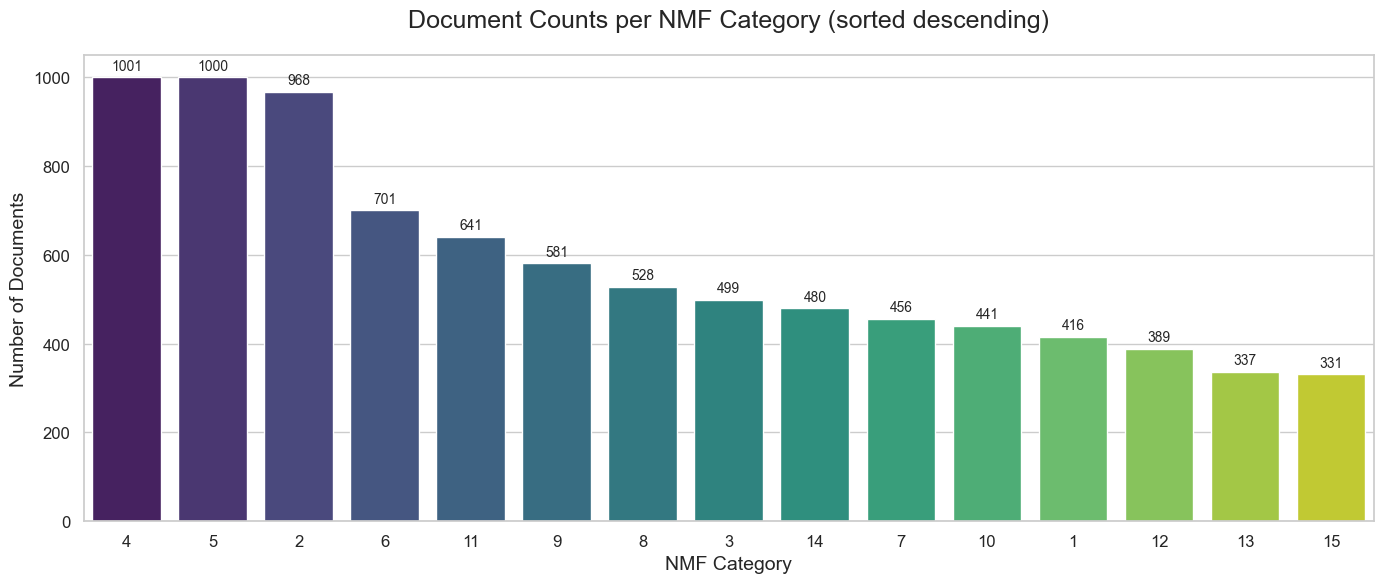

In [81]:
# Recreate counts from provided data
counts = {
    1: 416, 2: 968, 3: 499, 4: 1001, 5: 1000,
    6: 701, 7: 456, 8: 528, 9: 581, 10: 441,
    11: 641, 12: 389, 13: 337, 14: 480, 15: 331
}
df_nmf_counts = pd.Series(counts)

# Sort by descending count
df_nmf_counts = df_nmf_counts.sort_values(ascending=False)

# Set Seaborn style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 6))

# Use a palette that has as many colors as we have bars
palette = sns.color_palette("viridis", len(df_nmf_counts))

sns.barplot(
    x=df_nmf_counts.index.astype(str),  # category labels, now in descending order
    y=df_nmf_counts.values,
    palette=palette
)

# Annotate counts on top of bars
for idx, value in enumerate(df_nmf_counts.values):
    plt.text(idx, value + 10, f"{value}", ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title("Document Counts per NMF Category (sorted descending)", fontsize=18, pad=20)
plt.xlabel("NMF Category", fontsize=14)
plt.ylabel("Number of Documents", fontsize=14)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [34]:
from sklearn.manifold import TSNE

# Ensure necessary variables exist
required = ['df_cleaned', 'tfidf', 'nmf_model', 'X_tfidf']
if not all(var in globals() for var in required):
    print("Please ensure df_cleaned, tfidf, nmf_model, and X_tfidf are defined in your session before running this visualization.")
else:
    # 1) Top terms bar chart
    n_top = 15
    terms = tfidf.get_feature_names_out()
    fig, axes = plt.subplots(2, 5, figsize=(20, 8), tight_layout=True)
    for topic_idx, ax in enumerate(axes.flatten()):
        comp = nmf_model.components_[topic_idx]
        top_i = comp.argsort()[-n_top:][::-1]
        top_terms = terms[top_i]
        weights = comp[top_i]
        ax.barh(np.arange(n_top)[::-1], weights[::-1])
        ax.set_yticks(np.arange(n_top)[::-1])
        ax.set_yticklabels(top_terms[::-1])
        ax.set_title(f"Topic {topic_idx}")
        ax.invert_yaxis()
    plt.suptitle("Top 10 Terms per NMF Topic", fontsize=16)
    plt.show()

    # 2) TSNE on document-topic weights
    W = nmf_model.transform(X_tfidf)  # doc-topic matrix
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    W2 = tsne.fit_transform(W)
    assignments = W.argmax(axis=1)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(W2[:, 0], W2[:, 1], c=assignments, s=5, cmap='tab10')
    plt.legend(*scatter.legend_elements(num=nmf_model.n_components), title="Topic")
    plt.title("t-SNE Projection of Document-Topic Weights")
    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.show()

Please ensure df_cleaned, tfidf, nmf_model, and X_tfidf are defined in your session before running this visualization.


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition      import NMF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition      import NMF

# 1) Build TF‑IDF
tfidf = TfidfVectorizer(max_features=1000)           # or whatever settings you used
X_tfidf = tfidf.fit_transform(df_cleaned["ProcessedText"])    # your cleaned documents

# 2) Fit NMF
n_topics = 10                                        # pick your number of topics
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_model.fit(X_tfidf)


NMF(n_components=10, random_state=42)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),      # 1 = unigrams, 2 = bigrams
    stop_words='english',    # optionally remove English stop‑words
    min_df=5,                # only keep tokens seen in ≥5 docs
    max_df=0.8,              # only keep tokens in ≤80% of docs
    token_pattern=r'(?u)\b\w\w+\b'
)

X_tfidf = tfidf.fit_transform(df_cleaned['ProcessedText'])


In [48]:
W = nmf_model.transform(X_tfidf)  # doc‑topic matrix


C:\Users\Antomiao\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


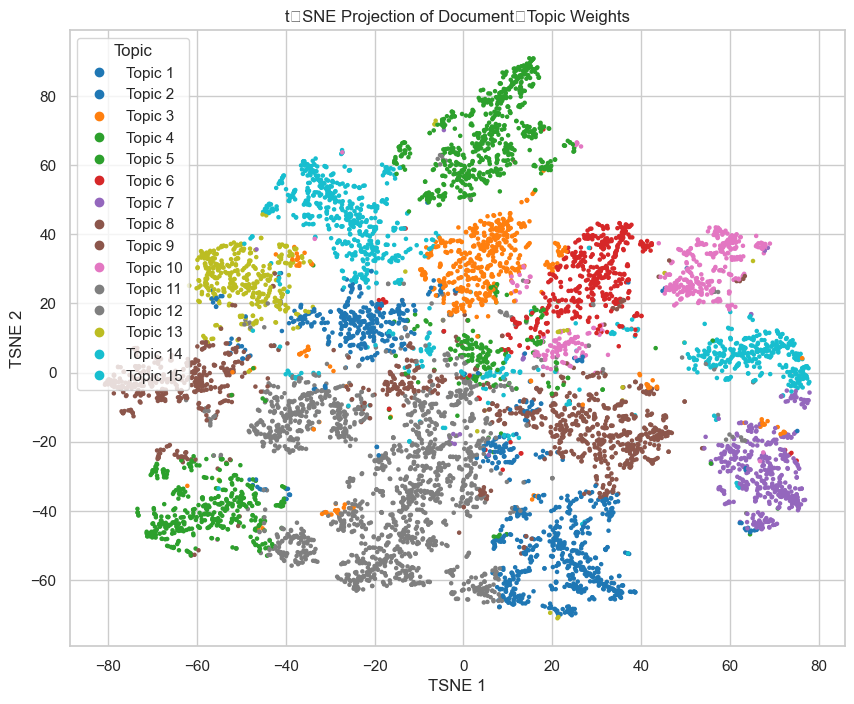

In [60]:
# after W = nmf_model.transform(X_tfidf)

# 1‑based topic assignment
assignments = W.argmax(axis=1) + 1

# TSNE projection
tsne = TSNE(n_components=2, random_state=12, init='pca')
W2 = tsne.fit_transform(W)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    W2[:, 0], W2[:, 1],
    c=assignments, s=5,
    cmap='tab10',
    vmin=1, vmax=nmf_model.n_components
)

# build 1‑based legend
handles, _ = scatter.legend_elements(num=nmf_model.n_components)
labels = [f"Topic {i}" for i in range(1, nmf_model.n_components+1)]
plt.legend(handles, labels, title="Topic", loc="best")

plt.title("t‑SNE Projection of Document‑Topic Weights")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()


In [2]:
df_cleaned=pd.read_csv('unsupervised_label_nlp_post.csv')


C:\Users\Antomiao\AppData\Local\Temp\ipykernel_20532\210152268.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\Antomiao\AppData\Local\Temp\ipykernel_20532\210152268.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


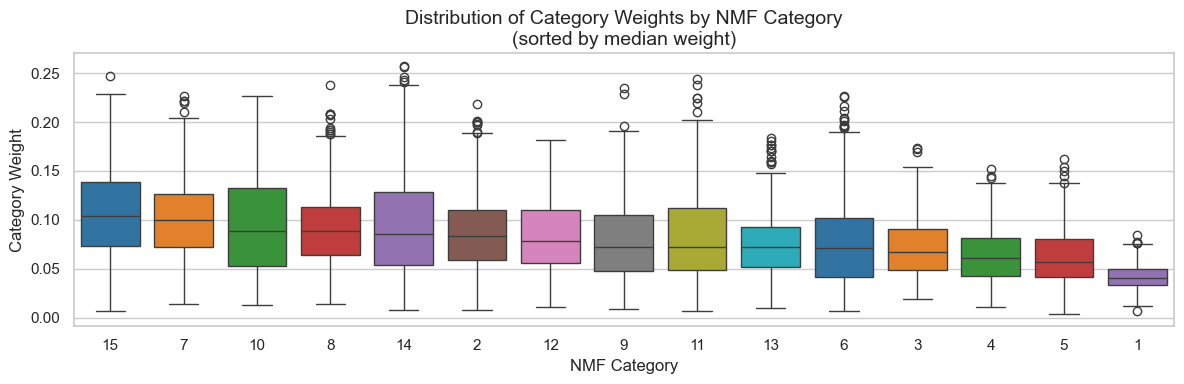

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Compute the “sort key” (here median weight) for each 0‑based topic
medians = (
    df_cleaned
      .groupby("NMF_Topic")["NMF_Topic_Weight"]
      .median()
      .sort_values(ascending=False)
)

# 2) Extract the sorted order (still 0‑based)
order_0based = medians.index.tolist()

# 3) Draw the boxplot, forcing that order
plt.figure(figsize=(12, 4))
ax = sns.boxplot(
    x="NMF_Topic",
    y="NMF_Topic_Weight",
    data=df_cleaned,
    order=order_0based,
    palette="tab10"
)

# 4) Relabel the ticks to be 1‑based
new_labels = [str(t + 1) for t in order_0based]
ax.set_xticklabels(new_labels)

# 5) Tidy up
plt.title("Distribution of Category Weights by NMF Category\n(sorted by median weight)", fontsize=14)
plt.xlabel("NMF Category", fontsize=12)
plt.ylabel("Category Weight", fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\Antomiao\AppData\Local\Temp\ipykernel_20532\3773485593.py:23: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
C:\Users\Antomiao\AppData\Local\Temp\ipykernel_20532\3773485593.py:23: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.pointplot(
C:\Users\Antomiao\AppData\Local\Temp\ipykernel_20532\3773485593.py:33: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Antomiao\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


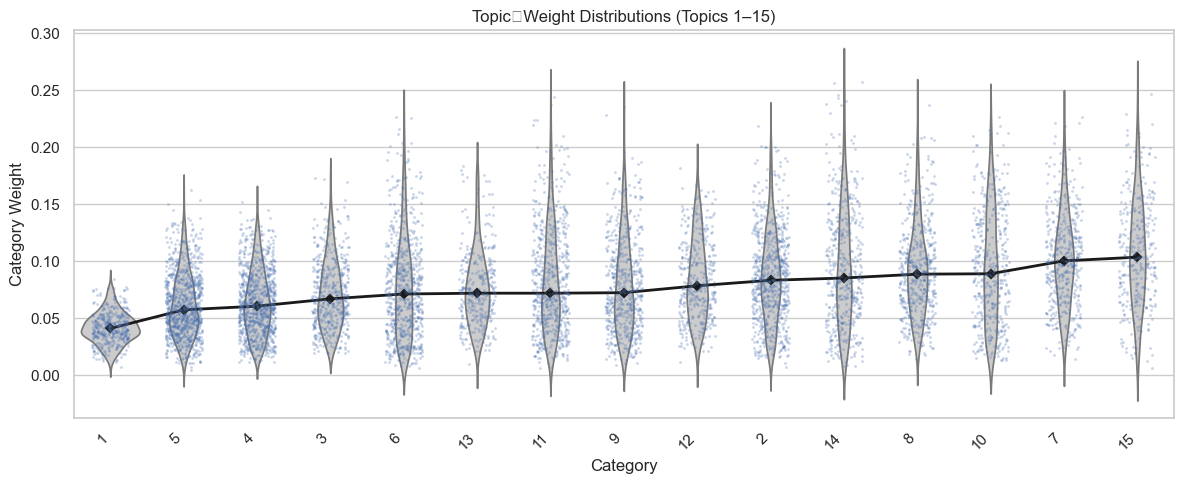

In [77]:
# add 1 to the topic index
df_cleaned["Topic1"] = df_cleaned["NMF_Topic"] + 1

# get median order in 1‑based terms
median_order1 = (
    df_cleaned.groupby("Topic1")["NMF_Topic_Weight"]
              .median()
              .sort_values()
              .index
    .tolist()
)

plt.figure(figsize=(12,5))

sns.violinplot(
    x="Topic1", y="NMF_Topic_Weight", data=df_cleaned,
    order=median_order1, inner=None, color=".8"
)
sns.stripplot(
    x="Topic1", y="NMF_Topic_Weight", data=df_cleaned,
    order=median_order1, size=2, jitter=0.25, alpha=0.3
)
sns.pointplot(
    x="Topic1", y="NMF_Topic_Weight", data=df_cleaned,
    order=median_order1, estimator=np.median,
    color="k", markers="D", scale=0.75, errwidth=0
)

plt.xticks(rotation=45, ha="right")
plt.title("Topic‑Weight Distributions (Topics 1–15)")
plt.xlabel("Category")
plt.ylabel("Category Weight")
plt.tight_layout()
plt.show()


In [64]:
df_year_topic = (
    df_cleaned
      .groupby(["Year", "NMF_Topic"])
      .size()
      .reset_index(name="Count")
)


Top 5 topics by total docs: [5, 4, 2, 6, 11]


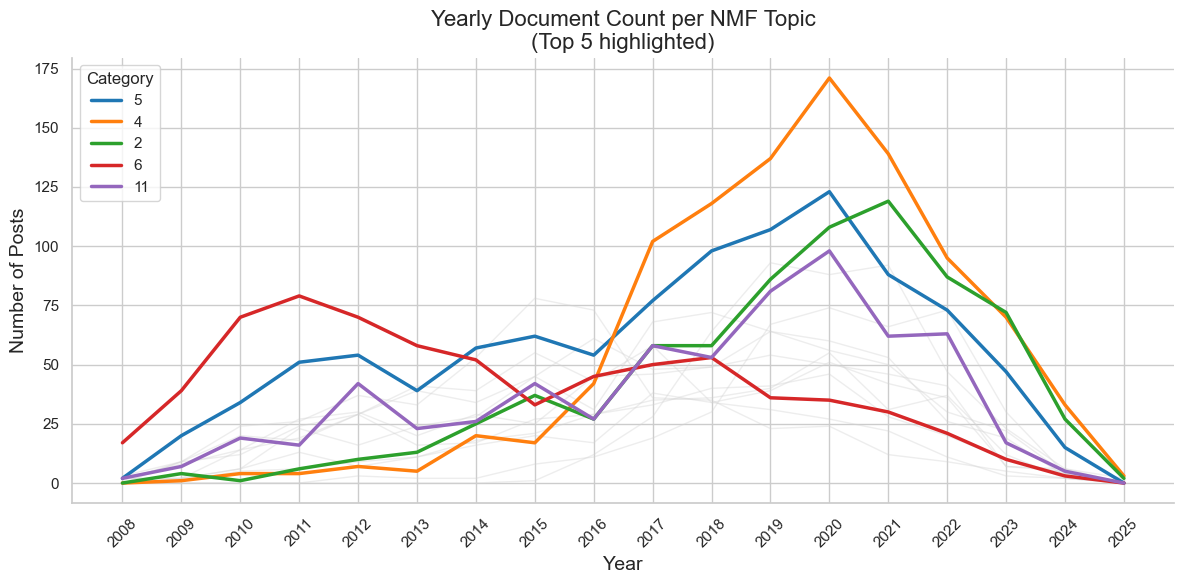

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2) Identify Top 5 topics by overall volume
totals = (
    df_year_topic
    .groupby("NMF_Topic")["Count"]
    .sum()
    .sort_values(ascending=False)
)
top5 = totals.index[:5].tolist()
print("Top 5 topics by total docs:", [t+1 for t in top5])

# 3) Plot: gray lines for all, bold for top 5 (1‑based labels)
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6), dpi=100)

years = sorted(df_year_topic["Year"].unique())

# a) all topics in light gray
for topic in df_year_topic["NMF_Topic"].unique():
    sub = df_year_topic[df_year_topic["NMF_Topic"] == topic]
    counts = sub.set_index("Year")["Count"].reindex(years, fill_value=0)
    plt.plot(
        years,
        counts,
        color="lightgray",
        linewidth=1,
        alpha=0.4
    )

# b) overlay the top 5 in color
palette = sns.color_palette("tab10", n_colors=len(top5))
for i, topic in enumerate(top5):
    sub = df_year_topic[df_year_topic["NMF_Topic"] == topic]
    counts = sub.set_index("Year")["Count"].reindex(years, fill_value=0)
    plt.plot(
        years,
        counts,
        label=f"{topic+1}",        # <-- shifted to 1-based
        color=palette[i],
        linewidth=2.5
    )

plt.title(
    "Yearly Document Count per NMF Topic\n(Top 5 highlighted)",
    fontsize=16
)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Posts", fontsize=14)
plt.xticks(years, rotation=45)
plt.legend(title="Category", loc="upper left")
sns.despine()
plt.tight_layout()
plt.show()


In [22]:
df_top15 = pd.read_csv('top10_nmf_posts_per_topic.csv')

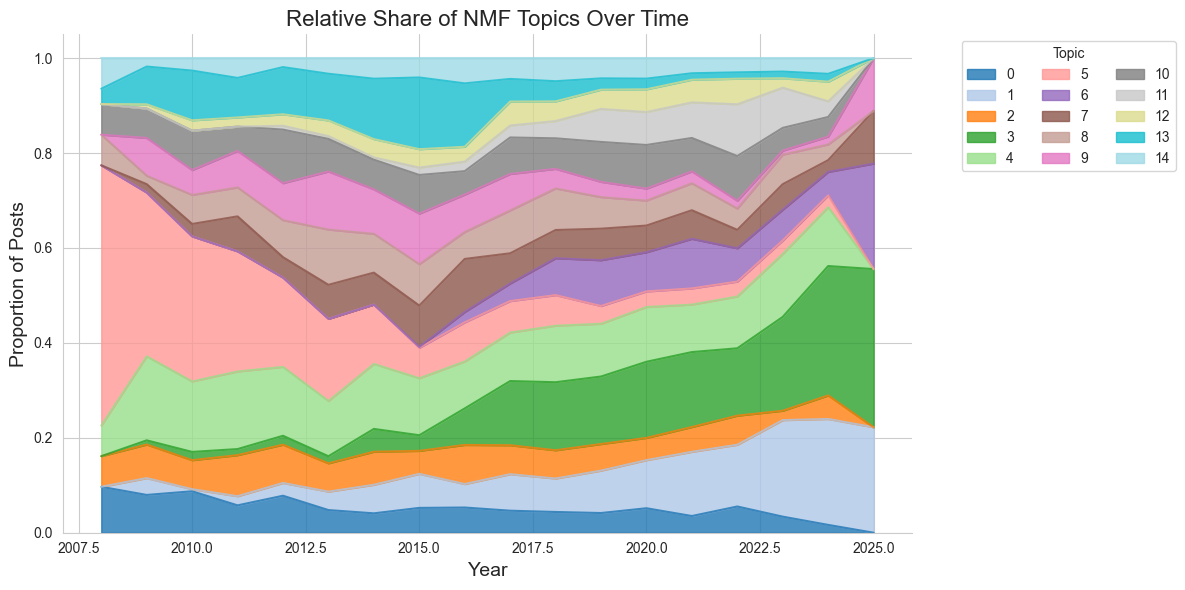

In [17]:
df_year_topic = (
    df_cleaned
      .groupby(["Year", "NMF_Topic"])
      .size()
      .reset_index(name="Count")
)


# Pivot into a wide DataFrame Year × Topic
df_pivot = (
    df_year_topic
      .pivot(index="Year", columns="NMF_Topic", values="Count")
      .fillna(0)
)

# (Optional) normalize to proportions
df_prop = df_pivot.div(df_pivot.sum(axis=1), axis=0)

# Plot stacked area
df_prop.plot(
    kind="area",
    figsize=(12,6),
    cmap="tab20",
    alpha=0.8
)
plt.title("Relative Share of NMF Topics Over Time", fontsize=16)
plt.ylabel("Proportion of Posts", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.legend(title="Topic", ncol=3, bbox_to_anchor=(1.05,1))
sns.despine()
plt.tight_layout()
plt.show()


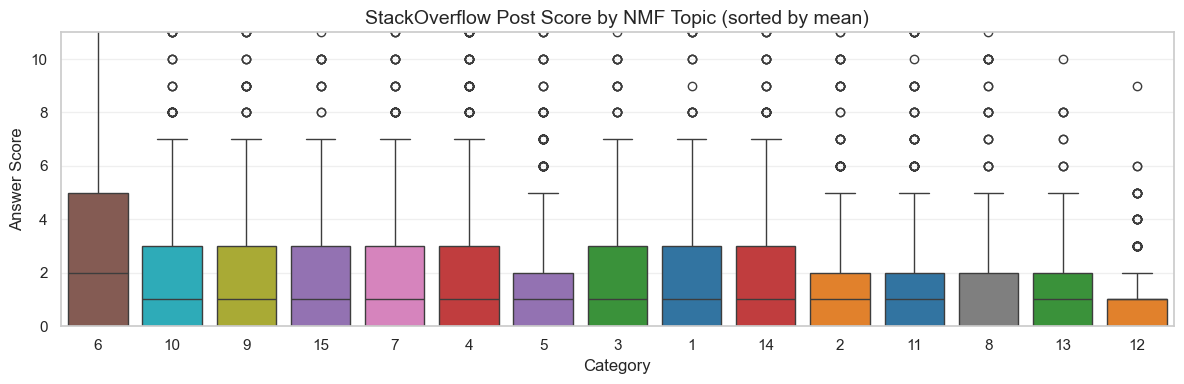

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Create a 1‑based “Topic” column
df_cleaned["Topic"] = df_cleaned["NMF_Topic"] + 1

# 2) Compute mean score per topic and sort descending
mean_scores = (
    df_cleaned
      .groupby("Topic")["Score"]
      .mean()
      .sort_values(ascending=False)
)
ordered_topics = mean_scores.index.tolist()

# 3) Plot
plt.figure(figsize=(12, 4))
ax = sns.boxplot(
    x="Topic",
    y="Score",
    data=df_cleaned,
    order=ordered_topics,     # use our new sorted order
    hue="Topic",              # map each topic to its own color
    palette="tab10",          # more than 10 distinct colors
    dodge=False               # only one box per topic
)
# remove the extra legend
ax.legend_.remove()

# 4) Tidy up
plt.title("StackOverflow Post Score by NMF Topic (sorted by mean)", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Answer Score", fontsize=12)
plt.ylim(0, df_cleaned["Score"].quantile(0.95))
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


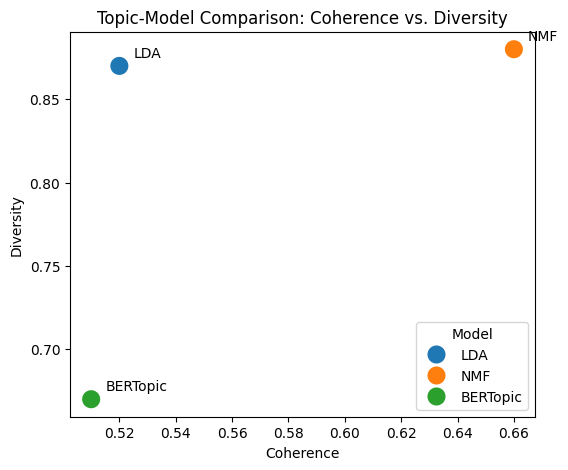

In [10]:
import pandas as pd

df_metrics = pd.DataFrame({
    "Model": ["LDA","NMF","BERTopic"],
    "Coherence": [0.52, 0.66, 0.51],
    "Diversity": [0.87, 0.88, 0.67]
})

plt.figure(figsize=(6,5))
sns.scatterplot(
    x="Coherence", 
    y="Diversity", 
    hue="Model", 
    s=200, 
    data=df_metrics
)
for _, row in df_metrics.iterrows():
    plt.text(
        row["Coherence"]+0.005, 
        row["Diversity"]+0.005, 
        row["Model"]
    )
plt.title("Topic‐Model Comparison: Coherence vs. Diversity")
plt.show()


## BERTopic

In [94]:
# --- 5) BERTopic ---
# 5a) Initialize SBERT embedder
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# 5b) Fit BERTopic
topic_model = BERTopic(embedding_model=embedder, verbose=False)
topics, probs = topic_model.fit_transform(texts)

# 5c) Show BERTopic summary
print("\n=== BERTopic Summary ===")
print(topic_model.get_topic_info())


=== BERTopic Summary ===
     Topic  Count                                        Name  \
0       -1   3986                  -1_word_text_sentence_like   
1        0    226          0_word2vec_vector_embeddings_embed   
2        1    193        1_similarity_cosine_distance_similar   
3        2    176              2_tree_dependency_parse_parser   
4        3    160                3_bert_fine_embeddings_token   
..     ...    ...                                         ...   
99      98     11  98_bachelor_regexnerannotator_degree_skill   
100     99     11                 99_stopwords_heart_df_white   
101    100     10          100_tweet_activism_hashtags_danger   
102    101     10       101_weka_classifier_instance_classify   
103    102     10                  102_csv_protect_excel_cell   

                                        Representation  \
0    [word, text, sentence, like, code, list, file,...   
1    [word2vec, vector, embeddings, embed, gensim, ...   
2    [similarity, c

In [ ]:
# (Optional) View top words for the first few BERTopic topics
for t_id in range(5):
    print(f"\nBERTopic Topic {t_id}:", topic_model.get_topic(t_id))

In [96]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Helper for diversity
def topic_diversity(topic_terms):
    all_terms = [w for t in topic_terms for w in t]
    return len(set(all_terms)) / len(all_terms)

try:
    # --- Prepare data/features as in your session ---
    texts     = df_cleaned["ProcessedText"].fillna("").tolist()
    tokenized = [doc.split() for doc in texts]
    dictionary= Dictionary(tokenized)
    corpus    = [dictionary.doc2bow(doc) for doc in tokenized]

    # TF–IDF & terms from your earlier vectorizer
    # (assuming tfidf and X_tfidf exist)
    # Otherwise, rebuild:
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf   = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")
    X_tfidf = tfidf.fit_transform(texts)
    terms   = tfidf.get_feature_names_out()

    # LDA & NMF topics (assuming lda and nmf exist)
    lda_topics = [[terms[i] for i in comp.argsort()[-10:][::-1]] 
                  for comp in lda.components_]
    nmf_topics = [[terms[i] for i in comp.argsort()[-10:][::-1]] 
                  for comp in nmf.components_]

    # BERTopic topics
    topic_info = topic_model.get_topic_info()
    bert_ids   = [tid for tid in topic_info['Topic'] if tid != -1]
    bert_topics= [[w for w,_ in topic_model.get_topic(tid)]
                  for tid in bert_ids]

    # Compute coherence
    lda_coh     = CoherenceModel(topics=lda_topics, texts=tokenized, dictionary=dictionary, coherence='c_v').get_coherence()
    nmf_coh     = CoherenceModel(topics=nmf_topics, texts=tokenized, dictionary=dictionary, coherence='c_v').get_coherence()
    bertopic_coh= CoherenceModel(topics=bert_topics, texts=tokenized, dictionary=dictionary, coherence='c_v').get_coherence()

    # Diversity
    lda_div     = topic_diversity(lda_topics)
    nmf_div     = topic_diversity(nmf_topics)
    bert_div    = topic_diversity(bert_topics)

    # Silhouette for BERTopic clusters
    from umap import UMAP
    emb         = embedder.encode(texts, show_progress_bar=False, normalize_embeddings=True)
    reduced     = UMAP(n_components=5, random_state=42).fit_transform(emb)
    labels_bert = np.array(topics)
    mask        = labels_bert >= 0
    sil_bert    = silhouette_score(reduced[mask], labels_bert[mask])

    # Compile metrics
    df_metrics = pd.DataFrame({
        "Model":           ["LDA", "NMF", "BERTopic"],
        "Coherence(c_v)":  [lda_coh, nmf_coh, bertopic_coh],
        "Diversity":       [lda_div, nmf_div, bert_div],
        "Silhouette":      [np.nan, np.nan, sil_bert]
    })
    print(df_metrics)
except Exception as e:
    print("Error computing metrics. Ensure lda, nmf, tfidf, X_tfidf, topic_model, embedder, topics are defined.", e)


      Model  Coherence(c_v)  Diversity  Silhouette
0       LDA        0.515960   0.866667         NaN
1       NMF        0.663026   0.880000         NaN
2  BERTopic        0.512745   0.668932    0.445154


In [95]:
def topic_diversity(topic_terms):
    all_terms = [w for t in topic_terms for w in t]
    return len(set(all_terms)) / len(all_terms)

print("LDA diversity:", topic_diversity(lda_topics))
print("NMF diversity:", topic_diversity(nmf_topics))


LDA diversity: 0.8666666666666667
NMF diversity: 0.88
